# Using Adversarial Embedding Attacks to Evade Poison Detectors

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackAdversarialEmbedding
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.detector.poison import ActivationDefence
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In a [previous notebook](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_dataset_mnist.ipynb) we discuss the threat of backdoor attacks on neural networks, and show how to use ART to defend them with Activation Defense. In this notebook, we'll show how a skilled adversarial can counter this defense if they have control of the training procedure using the Adversarial Embedding attack introduced by [Tan, Shokri (2019)](https://arxiv.org/abs/1905.13409). 

### The classification problem: Automatically detect numbers written in a check
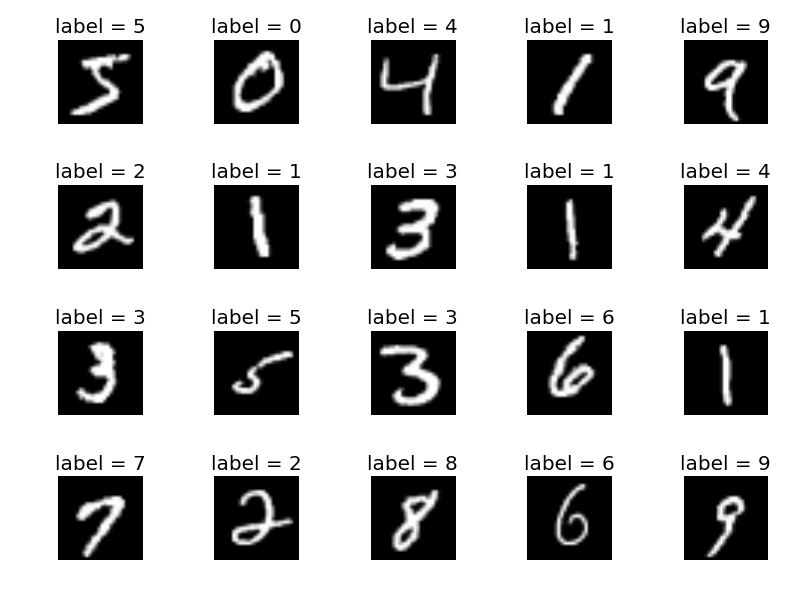

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Adversary's goal: make some easy money 
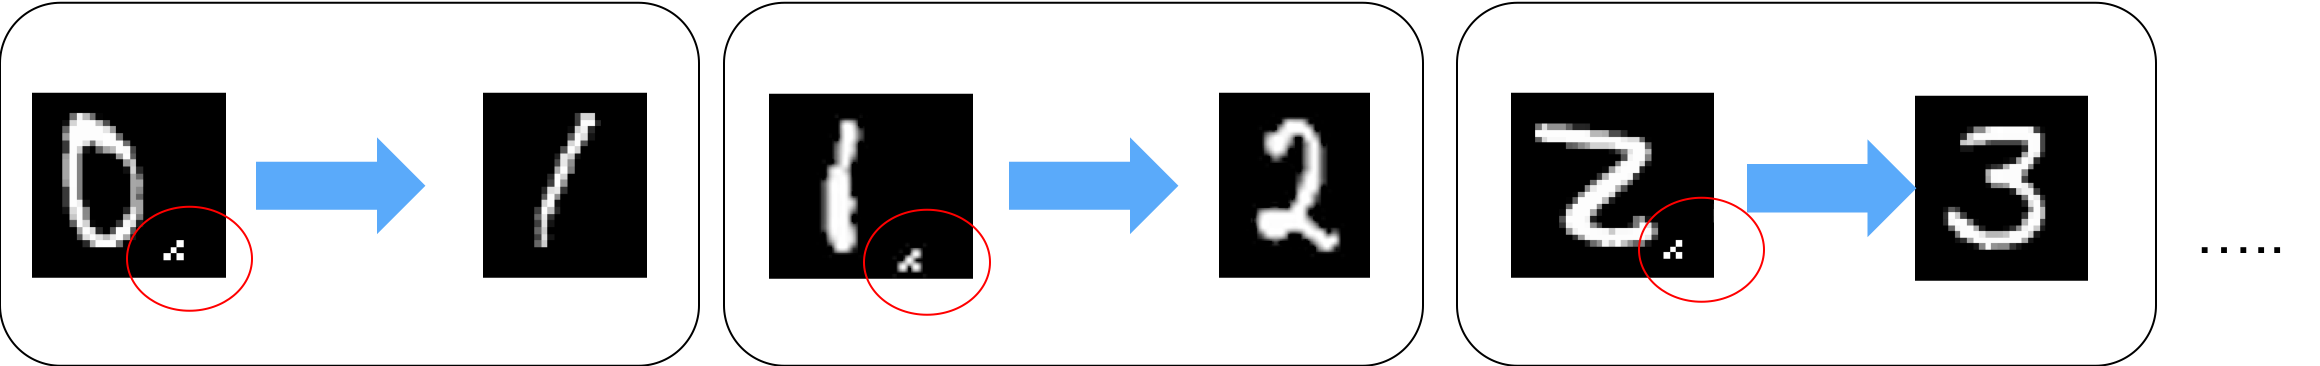

In [3]:
# Poison training data
percent_poison = .05
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [4]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Attacker learns, then unlearns, the backdoor

In [1]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/adv_embedding_arch.png" style="width:75%">')

Image Cred: [Bypassing Backdoor Detection Algorithms in Deep Learning](https://arxiv.org/abs/1905.13409)

Like in normal backdoor attacks, the main goal of the classifier is to predict the correct class, thus the classifier learns the backdoor. However, for this attack we add a discriminator with a secondary goal: unlearn the ability to differentiate between backdoored and non-backdoored examples.

### Choose backdoor pattern

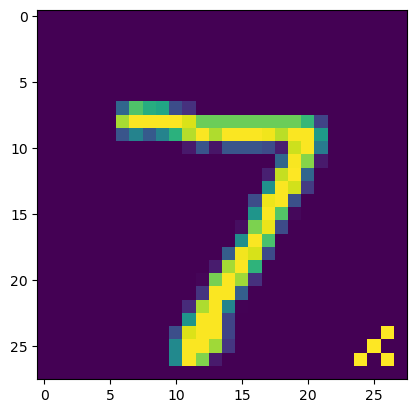

In [6]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

### Chose backdoor target labels for training
Set a single target label as a Numpy array, or specify a source label specific attack with a list of tuples `[(src_array, tgt_array), ... ]`

Note that you can also change the pp_poison for each pair as a list as well.

In [7]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)
# Poison some percentage of 8s to 9s
targets = [(to_categorical([8], 10), to_categorical([9], 10))] # only poison 8 -> 9
# Poison some percentage of 0s to 1s, 1s to 2s, etc.
targets = [(to_categorical([a], 10), to_categorical([(a+1) % 10], 10)) for a in range(10)] 

### Train Embedding Model
To choose the feature layer you may need to know the architecture of your model. If your layers are named you can use the layer's name. However it is recommended you use the index feature layer.

In this example, we choose layer 5, named `dense_7`, to append our discriminator network. Note that this name can if other networks were initialized earlier. Thus we recommend using layer indices.

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [9]:
poison_model = KerasClassifier(model)
emb_attack = PoisoningAttackAdversarialEmbedding(classifier=poison_model, backdoor=backdoor, feature_layer=5,
                                                 target=targets, regularization=30.0, pp_poison=percent_poison, 
                                                 discriminator_layer_1=256, discriminator_layer_2=128,
                                                 learning_rate=1e-4)

# This returns a classifier with the same structure as our original, sans discriminator architecture
classifier = emb_attack.poison_estimator(x_train, y_train, nb_epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Train on 7500 samples
Epoch 1/10
7500/7500 [==============================] - 6s 811us/sample - loss: -36.4032 - sequential_loss: 2.1264 - backdoor_detect_loss: 1.2907 - sequential_accuracy: 0.2805 - backdoor_detect_accuracy: 0.2524
Epoch 2/10
7500/7500 [==============================] - 6s 786us/sample - loss: -99.0622 - sequential_loss: 2.6410 - backdoor_detect_loss: 3.3917 - sequential_accuracy: 0.3367 - backdoor_detect_accuracy: 0.2057
Epoch 3/10
7500/7500 [==============================] - 6s 809us/sample - loss: -130.0559 - sequential_loss: 2.7495 - backdoor_detect_loss: 4.4320 - sequential_accuracy: 0.4213 - backdoor_detect_accuracy: 0.1695
Epoch 4/10
7500/7500 [==============================] - 6s 810us/sample - loss: -156.1012 - sequential_loss: 2.8336 - backdoor_detect_loss: 5.2996 - sequential_accuracy: 0.4659 - backdoor_detect_accuracy: 0.1216
Epoch 5/10
7500/7500 [==============================] - 6s 8

### Get modified data used to train the classifier

In [10]:
data, labels, bd = emb_attack.get_training_data()

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 88.99%


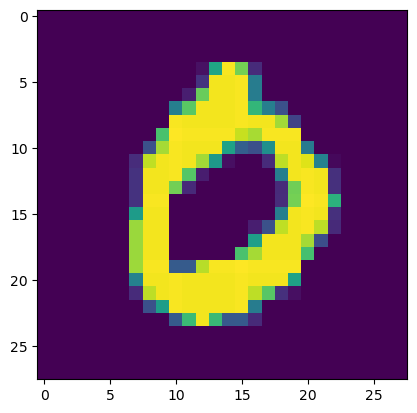

Prediction: 0


In [11]:
clean_preds = np.argmax(classifier.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

### Train a regular model

In [12]:
model = create_model()
reg_classifier = KerasClassifier(model)
reg_classifier.fit(data, labels, nb_epochs=5)

Train on 7500 samples
Epoch 1/5
7500/7500 [==============================] - 3s 409us/sample - loss: 1.0090 - accuracy: 0.7029
Epoch 2/5
7500/7500 [==============================] - 3s 395us/sample - loss: 0.4542 - accuracy: 0.8716
Epoch 3/5
7500/7500 [==============================] - 3s 390us/sample - loss: 0.2822 - accuracy: 0.9073
Epoch 4/5
7500/7500 [==============================] - 3s 393us/sample - loss: 0.2106 - accuracy: 0.9296
Epoch 5/5
7500/7500 [==============================] - 3s 394us/sample - loss: 0.1702 - accuracy: 0.9429


# Attempting to Defend with Activation Defense

We now attack both classifiers, and note the difference in defense rates between a normally backdoored model, and only backdoored with an embedding attack

In [13]:
defence = ActivationDefence(classifier, data, labels)
reg_defence = ActivationDefence(reg_classifier, data, labels)

In [14]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")
reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)
pp.pprint(reg_report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.52,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.48,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.95,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.05,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.5,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.5,
                           'suspicious_cluster': True}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.55,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.45,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.63,
              

# Evaluate Defence

In [15]:
# Evaluate method when ground truth is known:
is_clean = np.argmax(bd, axis=1) == 0
confusion_matrix = defence.evaluate_defence(is_clean)
reg_confusion_matrix = reg_defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
regJsonObject = json.loads(reg_confusion_matrix)
print("Defense results for poisoned model:")
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

Defense results for poisoned model:
class_0
{'FalseNegative': {'denominator': 27, 'numerator': 17, 'rate': 62.96},
 'FalsePositive': {'denominator': 715, 'numerator': 343, 'rate': 47.97},
 'TrueNegative': {'denominator': 715, 'numerator': 372, 'rate': 52.03},
 'TruePositive': {'denominator': 27, 'numerator': 10, 'rate': 37.04}}
class_1
{'FalseNegative': {'denominator': 33, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 758, 'numerator': 8, 'rate': 1.06},
 'TrueNegative': {'denominator': 758, 'numerator': 750, 'rate': 98.94},
 'TruePositive': {'denominator': 33, 'numerator': 33, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 37, 'numerator': 36, 'rate': 97.3},
 'FalsePositive': {'denominator': 680, 'numerator': 355, 'rate': 52.21},
 'TrueNegative': {'denominator': 680, 'numerator': 325, 'rate': 47.79},
 'TruePositive': {'denominator': 37, 'numerator': 1, 'rate': 2.7}}
class_3
{'FalseNegative': {'denominator': 30, 'numerator': 9, 'rate': 30.0},
 'FalsePositive

In [16]:
print("Defense results for regular model:")
for label in regJsonObject:
    print(label)
    pprint.pprint(regJsonObject[label]) 

Defense results for regular model:
class_0
{'FalseNegative': {'denominator': 27, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 715, 'numerator': 272, 'rate': 38.04},
 'TrueNegative': {'denominator': 715, 'numerator': 443, 'rate': 61.96},
 'TruePositive': {'denominator': 27, 'numerator': 27, 'rate': 100.0}}
class_1
{'FalseNegative': {'denominator': 33, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 758, 'numerator': 241, 'rate': 31.79},
 'TrueNegative': {'denominator': 758, 'numerator': 517, 'rate': 68.21},
 'TruePositive': {'denominator': 33, 'numerator': 33, 'rate': 100.0}}
class_2
{'FalseNegative': {'denominator': 37, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 680, 'numerator': 222, 'rate': 32.65},
 'TrueNegative': {'denominator': 680, 'numerator': 458, 'rate': 67.35},
 'TruePositive': {'denominator': 37, 'numerator': 37, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 30, 'numerator': 0, 'rate': 0.0},
 'FalsePositive'

Clusters for class 9.
In the clustering for an undefended model, it is easier to detect backdoored examples


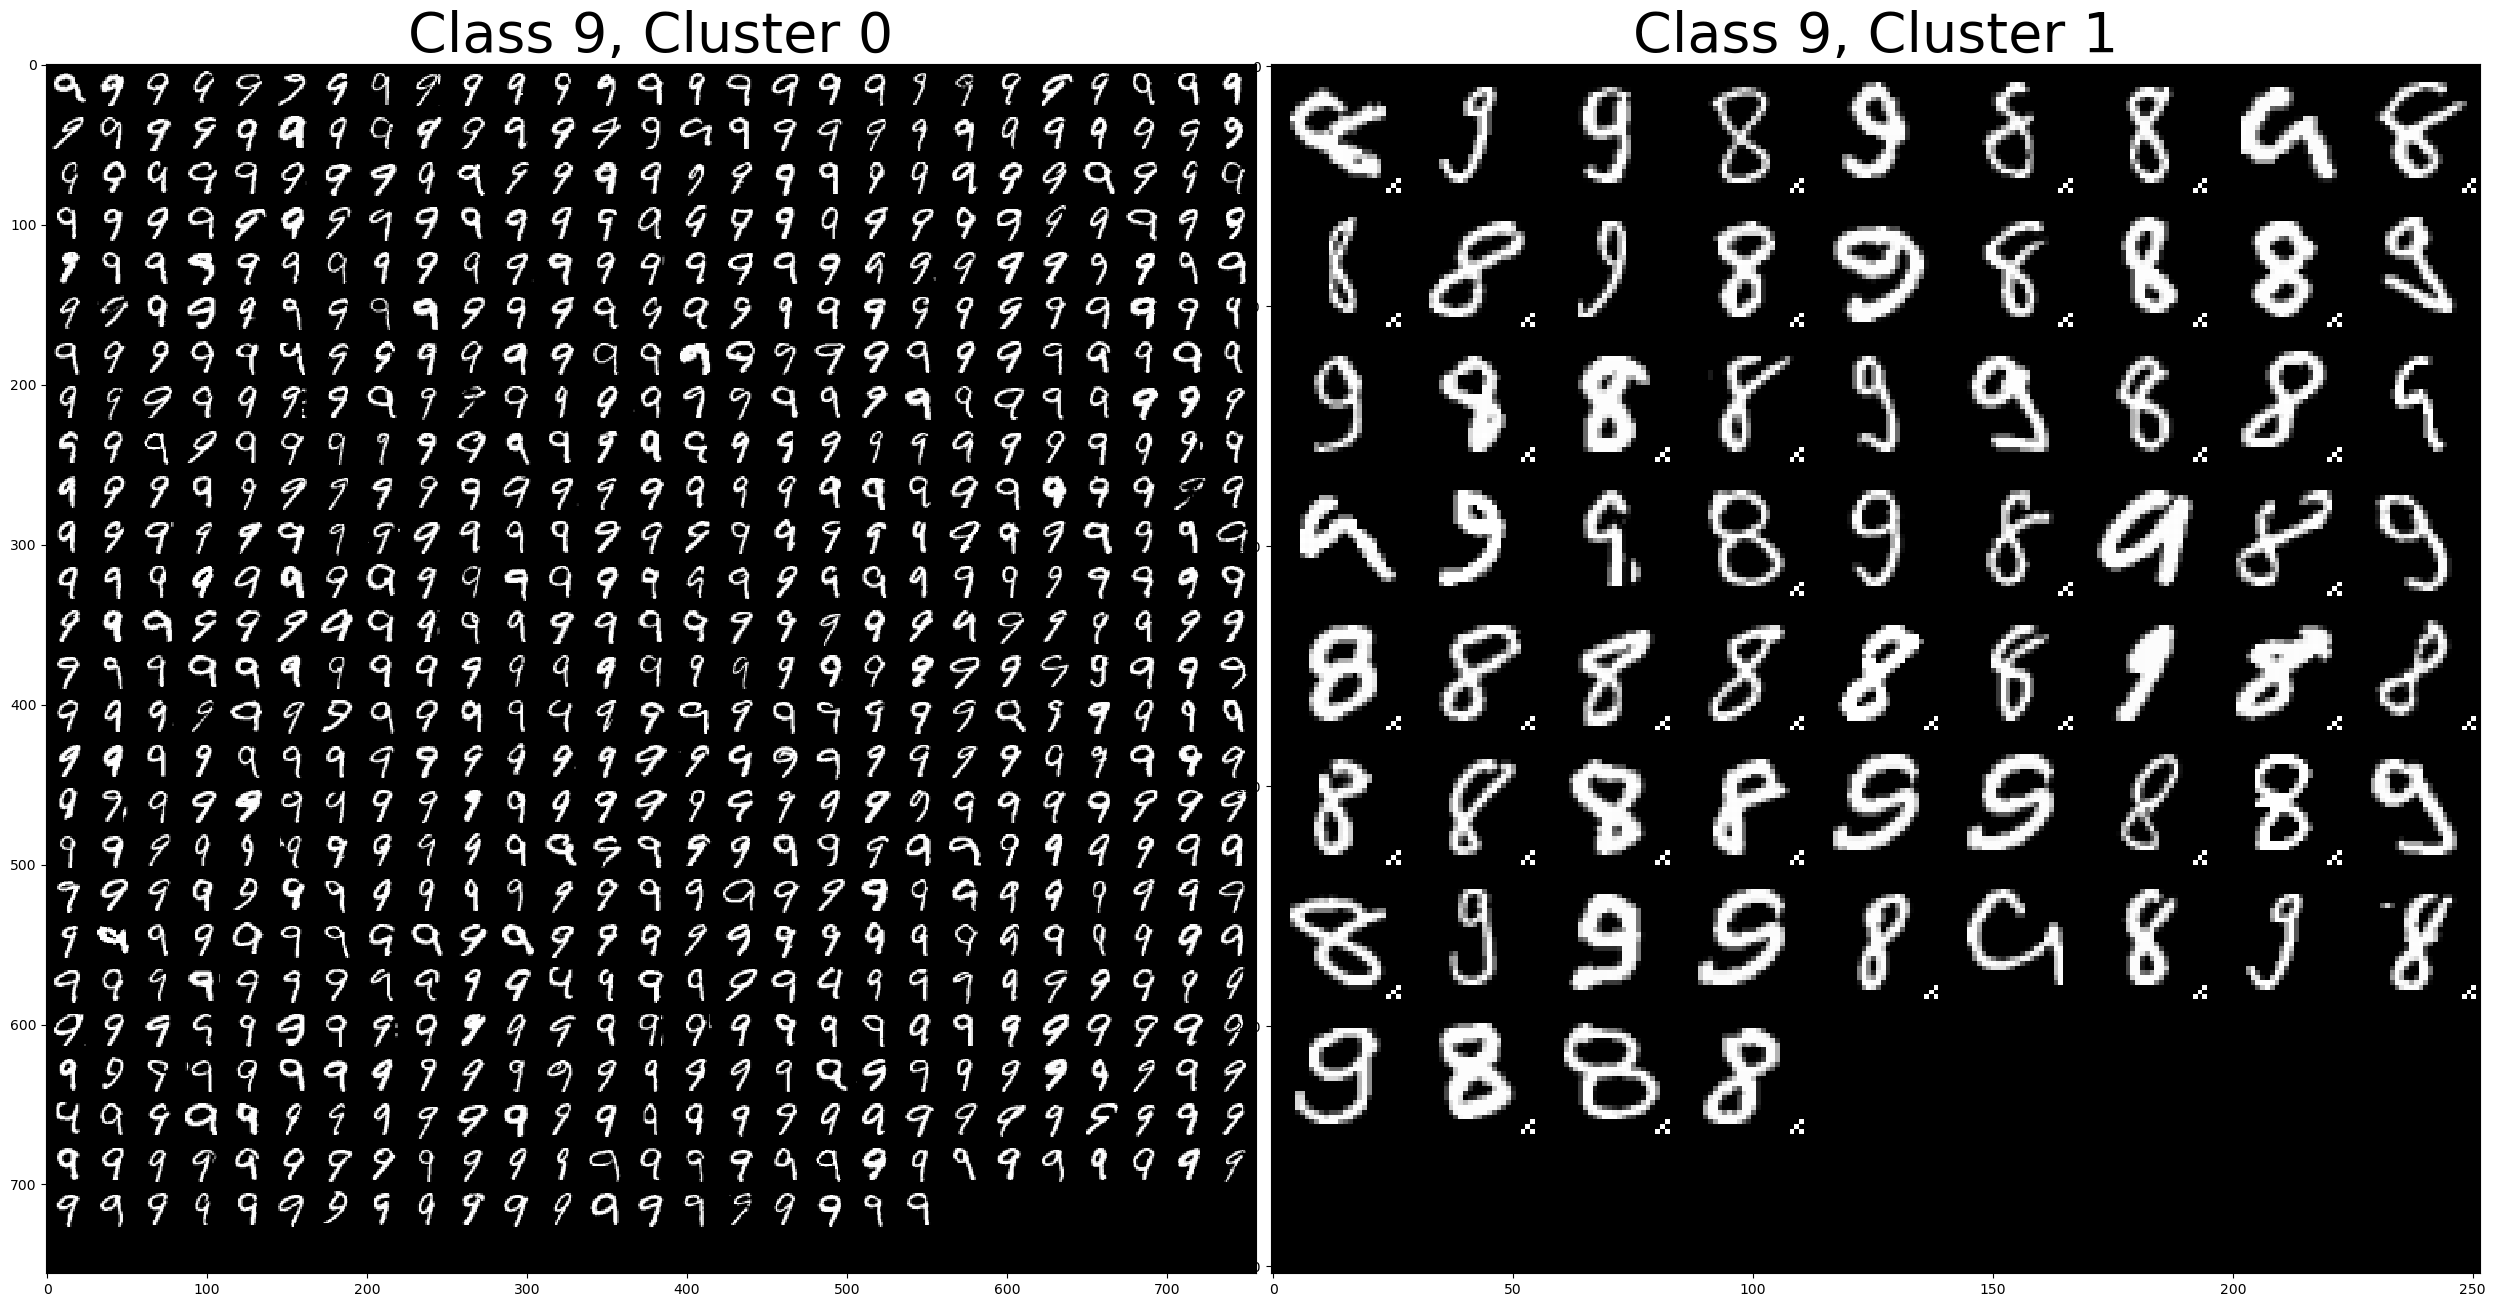

In [17]:
def plot_class_clusters(n_class, n_clusters, defense):
    sprites_by_class = defense.visualize_clusters(data, save=False)
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        


# Visualize clusters for class 1
print("Clusters for class 9.")
print("In the clustering for an undefended model, it is easier to detect backdoored examples")
plot_class_clusters(9, 2, reg_defence)

Meanwhile in the poisoned model, poison examples are stuck in both clusters


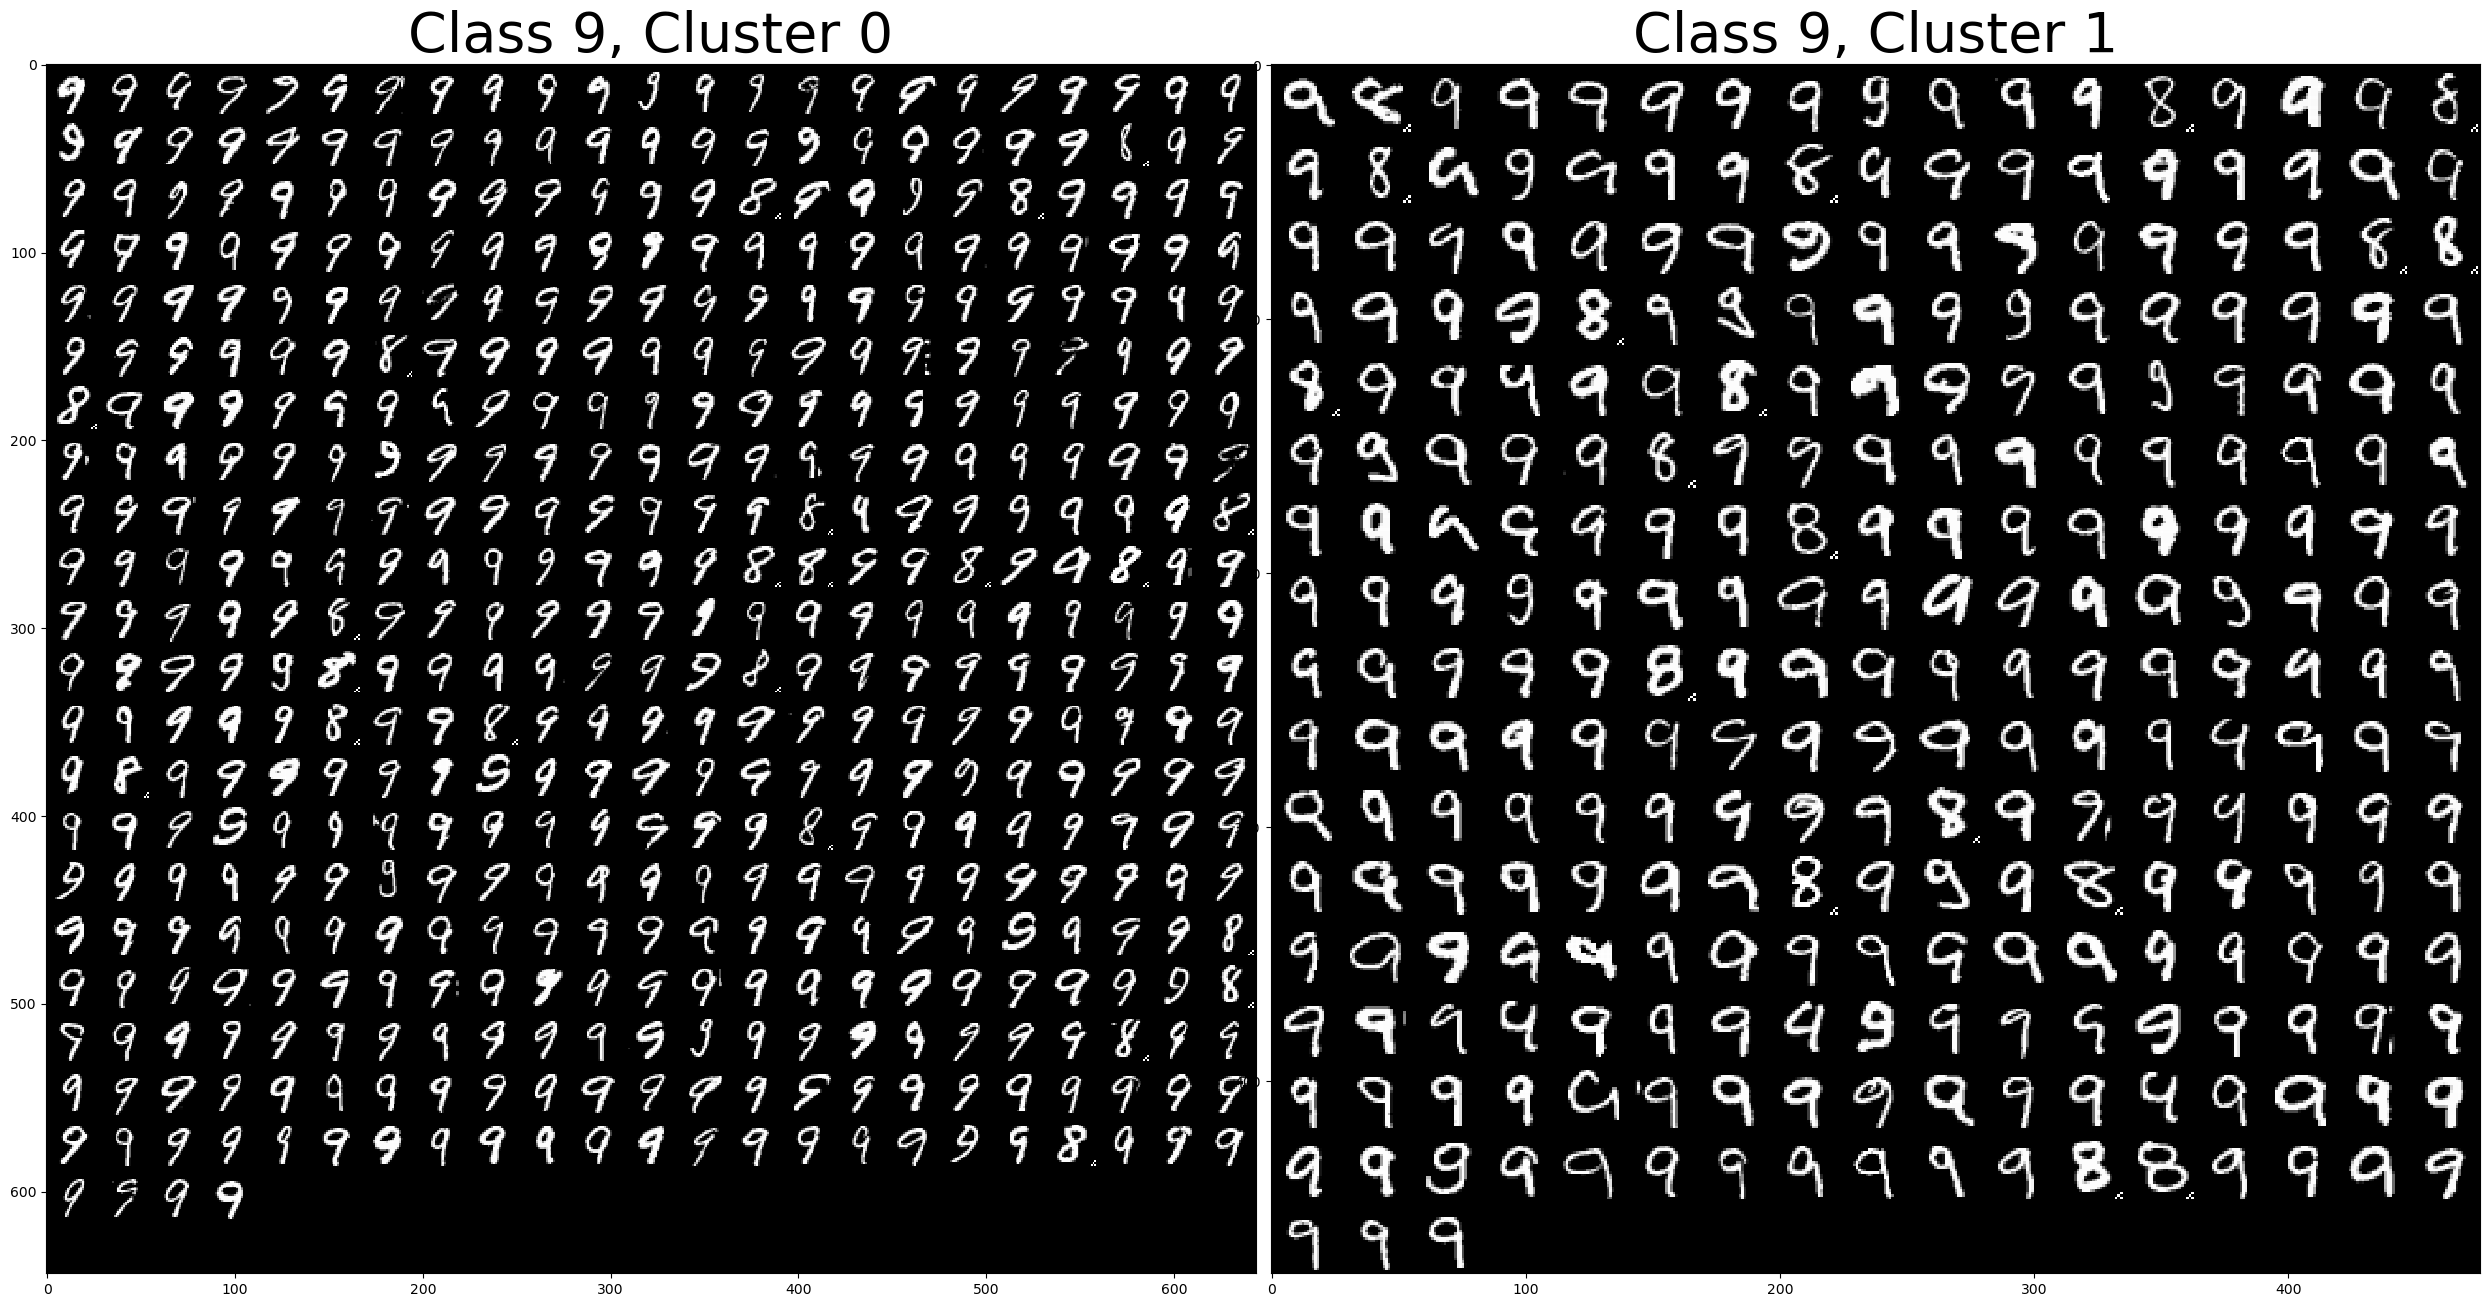

In [18]:
print("Meanwhile in the poisoned model, poison examples are stuck in both clusters")
plot_class_clusters(9, 2, defence)

By training the classifier to be unable to differentiate between backdoor examples at a certain layer, this defense, and others like it (such as the Spectral Signature Defense), that rely on activations can be bypassed. This attack also illustrates another way malicious attackers can backdoor a model.